# Symbols Detection using custom torchvision model

> how to build a custom torchvision model for symbols detection and fine-tune the model for detecting symbols in large large engineering drawings.

Here's what I'll go over:

- Install required libraries
- Build and pre-processing dataset
- Fine-tune the model for large engineering drawings
- Evaluate the model
- Look at some predictions

How good our final model is going to be?

In [1]:
!nvidia-smi

Mon Jul 13 10:40:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 940MX      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0    N/A /  N/A |   1999MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

## Prerequisites

Let's start by installing required libraries for th project:

In [2]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy
!pip install PyYAML==5.3.1
# uncomment for windows
!pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/philferriere/cocoapi.git to c:\users\mohan\appdata\local\temp\pip-req-build-qlqc7631
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-win_amd64.whl size=81606 sha256=fd3ebda853edb6e32619cde8df80365b8e7086b70b4752fbc10e6a5d981ad64d
  Stored in directory: C:\Users\Mohan\AppData\Local\Temp\pip-ephem-wheel-cache-8vad9069\wheels\bd\1c\0d\8c82e1b9bc855b82e1eb53eadea4459efe171d2daf5a222701
Successfully built pycocotools


  Running command git clone -q https://github.com/philferriere/cocoapi.git 'C:\Users\Mohan\AppData\Local\Temp\pip-req-build-qlqc7631'


I'll also install Apex by NVIDIA to speed up the training of my model (this step is optional):

In [3]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" && cd .. && rm -rf apex

fatal: destination path 'apex' already exists and is not an empty directory.


### Let's import all required libraries:

In [5]:
from pathlib import Path
from random import randint
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

# Start tensorboard (optional)
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}  --host localhost

np.random.seed(42)

Reusing TensorBoard on port 6006 (pid 1784), started 15:09:18 ago. (Use '!kill 1784' to kill it.)

### Load and prepare the dataset

In [2]:
df =pd.read_csv('data/Symbols_pixel.csv', header=None)

# column names
column_names =  ['pixel_' + str(i) for i in range(1, df.shape[1])]
column_names.append('label')
df.columns = column_names

df.columns
print(df.shape)
df.head()

(2432, 10001)


,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,pixel_10000,label
0,0,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,Arrowhead
1,255,255,255,255,255,255,255,255,255,255,...,255,0,0,0,0,0,0,0,0,Arrowhead
2,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,255,255,255,Arrowhead
3,255,255,255,255,255,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,Arrowhead
4,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,Arrowhead


In [3]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# extract labels
labels =df[column_names[-1]]
features= df[column_names[:-1]]
features.head()
type(labels)

pandas.core.series.Series

#### Show some random symbols (EDA)

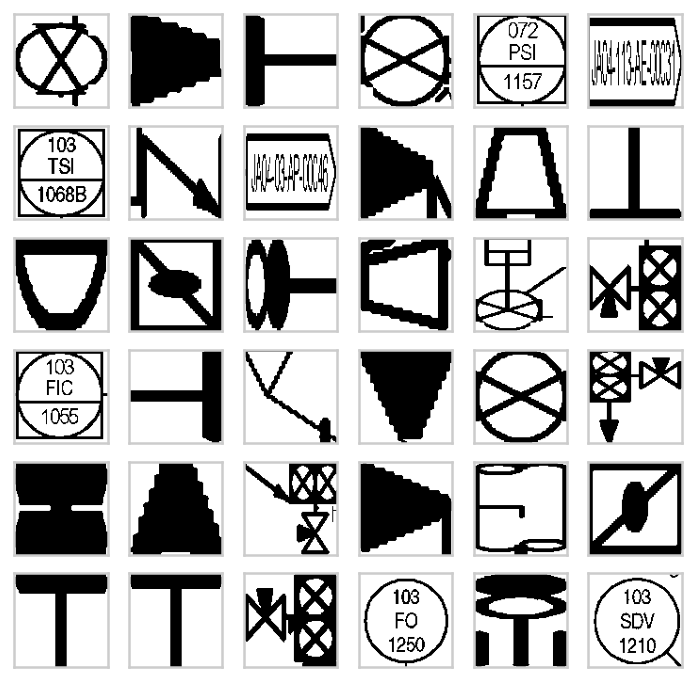

In [4]:
fig, ax = plt.subplots(6, 6, figsize=(6, 6))
fx = features.values # returns numpy array

for i, axi in enumerate(ax.flat):
    value = randint(0, df.shape[0])
    axi.imshow(fx[value].reshape(100,100), cmap='gray')
    axi.set(xticks=[], yticks=[])

### Check and remove least frequent symbols
- Some classes rarely appear
- and needs to be removed,
- first check the numbers

In [5]:
## check class distribution 
df['label'].value_counts()

Sensor                        392
Reducer                       285
Arrowhead                     240
Valve Ball                    173
DB&BBV                        127
Valve Check                   126
Continuity Label              116
DB&BPV                        113
Valve Plug                     88
Arrowhead + Triangle           83
Triangle                       74
Valve Butterfly                71
ESDV Valve Ball                65
Flange Single T-Shape          61
Flange Joint                   46
Injector Point                 43
Spectacle Blind                42
Valve                          40
DB&BBV + Valve Check           39
Valve Globe                    28
Valve Angle                    27
Valve Slab Gate                24
Control Valve Globe            23
Flange + Triangle              17
Control                        13
Exit to Atmosphere             12
Rupture Disc                   10
ESDV Valve Slab Gate            9
Box                             7
ESDV Valve But

Remove symbols with less than 10 instances in the dataset

In [6]:
df = df[~df['label'].isin(['Ultrasonic Flow Meter', 'Barred Tee','Temporary Strainer', 'ESDV Valve Butterfly',
                           'Control Valve Angle Choke','Line Blindspacer', 'Box', 'ESDV Valve Slab Gate',
                           'Vessel', 'Valve Gate Through Conduit','Deluge','Control Valve'])]

# df['label'].value_counts()

Let's get all unique categories:

In [7]:
categories = list(df.label.unique())
print(len(categories), categories)

27 ['Arrowhead', 'Arrowhead + Triangle', 'Continuity Label', 'Control', 'Control Valve Globe', 'DB&BBV', 'DB&BBV + Valve Check', 'DB&BPV', 'ESDV Valve Ball', 'Exit to Atmosphere', 'Flange + Triangle', 'Flange Joint', 'Flange Single T-Shape', 'Injector Point', 'Reducer', 'Rupture Disc', 'Sensor', 'Spectacle Blind', 'Triangle', 'Valve', 'Valve Angle', 'Valve Ball', 'Valve Butterfly', 'Valve Check', 'Valve Globe', 'Valve Plug', 'Valve Slab Gate']


We have 27 different categories. Let's split the data into a training and validation set:

In [8]:
train, validation = train_test_split(df.values, test_size=0.2)
len(train), len(validation)

(1902, 476)

### Convert to darknet format

Model requires the dataset to be in the *darknet format*. Here's an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: `class_index bbox_x_center bbox_y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1

Creating a helper function that builds a dataset in the correct format for us:

In [9]:
def create_dataset(dataset, categories, dataset_type):
    
    images_path = Path(f"data/images/{dataset_type}")
    images_path.mkdir(parents=True, exist_ok=True)

    labels_path = Path(f"data/labels/{dataset_type}")
    labels_path.mkdir(parents=True, exist_ok=True)
    
    img_id = 1
    for i in dataset:
    
        features = list(i)
        label = features.pop(-1)
        features = np.array(features)
        
        plt.ioff()
        fig = plt.figure(figsize=(3,3))
        plt.axis('off')
        plt.imshow(features.reshape(100,100), cmap='gray')
        plt.savefig('sample_read.png')
        plt.close(fig)

        img = cv2.imread("sample_read.png")
        w, h, c = img.shape
        x1, y1 = 0, 0
        x2, y2 = x1 + w, y1+ h

        cv2.rectangle(
            img,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color=(0, 255, 0),
            thickness=2
        )

        ((label_width, label_height), _) = cv2.getTextSize(
            label, 
            fontFace=cv2.FONT_HERSHEY_PLAIN,
            fontScale=1.25, 
            thickness=2
        )

        cv2.rectangle(
            img,
            (int(x1), int(y1)),
            (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
            color=(0, 255, 0),
            thickness=cv2.FILLED
        )

        cv2.putText(
            img,
            label,
            org=(int(x1), int(y1 + label_height + label_height * 0.25)), # bottom left
            fontFace=cv2.FONT_HERSHEY_PLAIN,
            fontScale=1.25,
            color=(255, 255, 255),
            thickness=2
        )
        
        image_name = f"{img_id}.jpeg"
        
        cv2.imwrite(os.path.join(images_path, image_name), img)
        
        label_name = f"{img_id}.txt"

        with (labels_path / label_name).open(mode="w") as label_file:
            
            category_idx = categories.index(label)
            
            bbox_width = (x1 + w / w) - x1
            bbox_height = (y1 + h / h) - y1

            label_file.write(
                f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
            )
        img_id += 1

In [12]:
create_dataset(train, categories, 'train')
create_dataset(validation, categories, 'validation')

## Fine-tuning model

The YOLO abbreviation stands for You Only Look Once. YOLO models are one stage object detectors. 

YOLO models are very light and fast. They are [not the most accurate object detections around](https://paperswithcode.com/sota/object-detection-on-coco), though. Ultimately, those models are the choice of many (if not all) practitioners interested in [real-time object detection (FPS >30)](https://paperswithcode.com/sota/real-time-object-detection-on-coco).

### Contreversy

Joseph Redmon introduced YOLO v1 in the 2016 paper [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf). The implementation uses the [Darknet Neural Networks library](https://pjreddie.com/darknet/).

He also co-authored the YOLO v2 paper in 2017  [YOLO9000: Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf). A significant improvement over the first iteration with much better localization of objects.

The final iteration, from the original author, was published in the 2018 paper [YOLOv3: An Incremental Improvement](https://arxiv.org/pdf/1804.02767.pdf).

Then things got a bit wacky. Alexey Bochkovskiy published [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934) on April 23, 2020. The project has [an open-source repository on GitHub](https://github.com/AlexeyAB/darknet).

YOLO v5 got open-sourced on [May 30, 2020](https://github.com/ultralytics/yolov5/commit/1e84a23f38fad9e52b59101e9f1246d93066ed1e) by [Glenn Jocher](https://github.com/glenn-jocher) from ultralytics. There is no published paper, but [the complete project is on GitHub](https://github.com/ultralytics/yolov5).

The community at Hacker News got into a [heated debate about the project naming](https://news.ycombinator.com/item?id=23478151). Even the guys at Roboflow wrote [Responding to the Controversy about YOLOv5](https://blog.roboflow.ai/yolov4-versus-yolov5/) article about it. They also did a great comparison between YOLO v4 and v5.

### model Traing 

In [ ]:
!python train.py --img 100 --batch 32 --epochs 200 \
  --data ./models/PandIDs.yaml --cfg ./models/base_x.yaml --weights ./weights/base_x.pt \
  --name PandIDs --cache

## Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

No handles with labels found to put in legend.


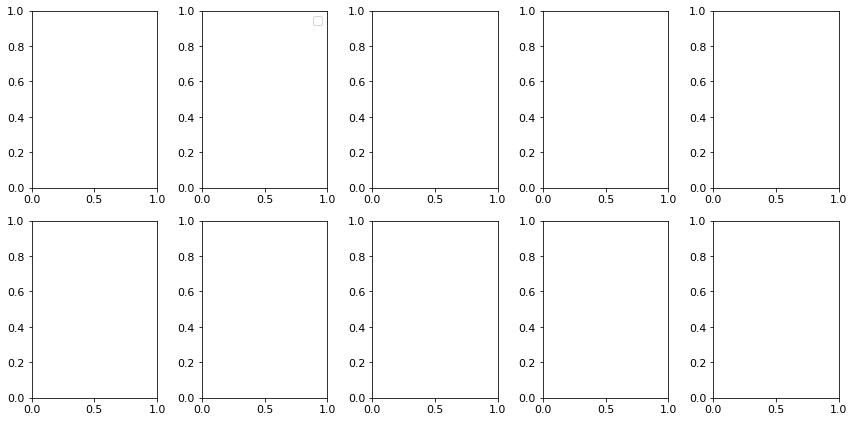

In [1]:
from utils.utils import plot_results

plot_results();

## Making predictions

Let's pick 50 images from the validation set and move them to `inference/images` to see how our model does on those:

Use the `detect.py` script to run our model on the images. Here are the parameters we're using:

- weights weights/best_PandIDs.pt - checkpoint of the model
- img 100 - resize the images to 100x100 px
- conf 0.4 - take into account predictions with confidence of 0.4 or higher
- source ./inference/images/ - path to the images

In [3]:
!python detect.py --weights runs/exp0_yolov5x_PandIDs/weights/best__PandIDs.pt \
  --img 100 --conf 0.4 --source ./inference/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=100, iou_thres=0.5, output='inference/output', save_txt=False, source='./inference/images/', update=False, view_img=False, weights=['runs/exp0_yolov5x_PandIDs/weights/best_yolov5x_PandIDs.pt'])
Using CUDA device0 _CudaDeviceProperties(name='GeForce 940MX', total_memory=4096MB)

Fusing layers... Model Summary: 284 layers, 8.85656e+07 parameters, 8.45317e+07 gradients
image 1/52 inference\images\1.jpeg: 128x128 1 Valve Plugs, Done. (0.122s)
image 2/52 inference\images\102.jpeg: 128x128 1 Reducers, Done. (0.111s)
image 3/52 inference\images\103.jpeg: 128x128 1 Valve Butterflys, Done. (0.119s)
image 4/52 inference\images\104.jpeg: 128x128 1 Flange Single T-Shapes, Done. (0.113s)
image 5/52 inference\images\106.jpeg: 128x128 1 ESDV Valve Balls, Done. (0.113s)
image 6/52 inference\images\111.jpeg: 128x128 1 Arrowheads, Done. (0.122s)
image 7/52 inference\images\114.jpeg: 128x128 1 Valve Globes, Don

We'll write a helper function to show the results:

In [6]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

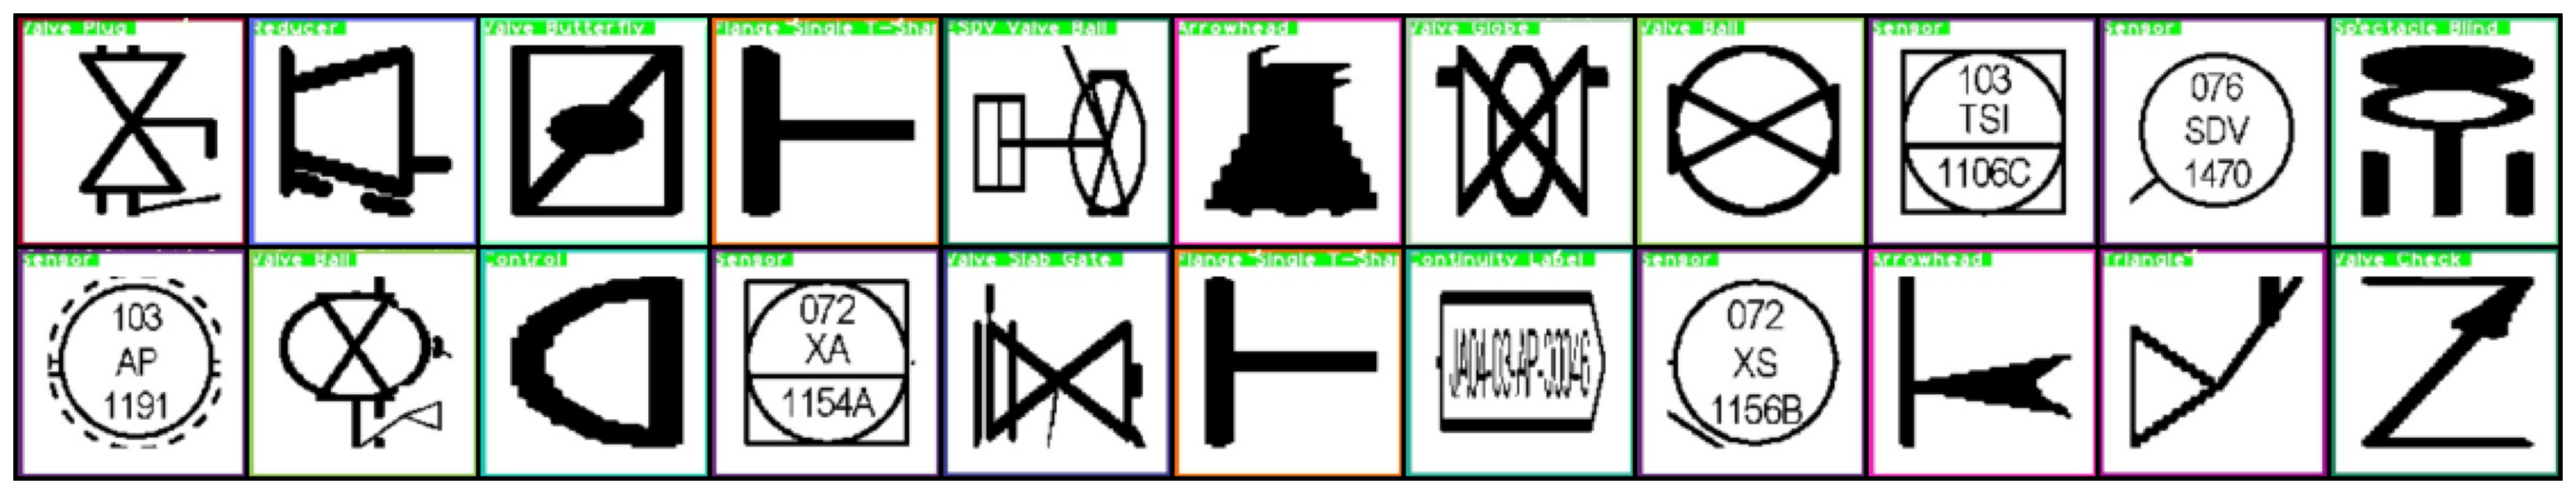

In [7]:
img_paths = list(Path("inference/output").glob("*.jpeg"))[:22]
show_grid(img_paths)

In [8]:
!python detect.py --weights runs/exp0_yolov5x_PandIDs/weights/best_yolov5x_PandIDs.pt \
  --img 1000 --conf 0.4 --source ./inference/images/Examples

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=1000, iou_thres=0.5, output='inference/output', save_txt=False, source='./inference/images/Examples', update=False, view_img=False, weights=['runs/exp0_yolov5x_PandIDs/weights/best_yolov5x_PandIDs.pt'])
Using CUDA device0 _CudaDeviceProperties(name='GeForce 940MX', total_memory=4096MB)

Fusing layers... Model Summary: 284 layers, 8.85656e+07 parameters, 8.45317e+07 gradients
image 1/8 inference\images\Examples\example1-1.jpg: 768x1024 2 Continuity Labels, Done. (1.232s)
image 2/8 inference\images\Examples\example1-2.jpg: 768x1024 1 Exit to Atmospheres, Done. (1.225s)
image 3/8 inference\images\Examples\example2-1.jpg: 704x1024 3 Continuity Labels, Done. (1.145s)
image 4/8 inference\images\Examples\example2-2.jpg: 704x1024 1 Continuity Labels, Done. (1.156s)
image 5/8 inference\images\Examples\example3-1.png: 768x1024 Done. (1.227s)
image 6/8 inference\images\Examples\example3-2.png: 768x1024 